<a href="https://colab.research.google.com/github/charismaticchiu/Adversarial_Resolution/blob/master/imagenette_3_class_loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install adversarial-robustness-toolbox
#!pip install foolbox
#!pip install opencv-python
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import glob
import os
import torch
import torchvision

pixelsize = 320 # 320
dataFolder = 'drive/My Drive/adv_img/crop_imagenette2-{}/'.format(pixelsize)

class1 = 'n02979186' # tape
class2 = 'n02102040' # dog
class3 = 'n03445777' # golf


In [0]:
from PIL import Image  
import numpy as np
import pdb, cv2

def path_to_np(paths):
  data = []
  for p in paths:
    im = Image.open(p)
    
    im = np.array(im)# .astype(np.float32)
    plt.imshow(im)
    # pdb.set_trace()
    if im.shape == (pixelsize, pixelsize, 3): # Make sure it is square RGB
      im = np.expand_dims(im, 0)
      #pdb.set_trace()
      data.append(im)
      #pdb.set_trace()
    else:
      print('Sth wrong with: {} Shape: {}'.format(os.path.basename(p), im.shape))
  return np.concatenate(data, 0)



def resizeDatasets(orig_dataset, tgt_size):
  #resized_datasets = []
  original_size = orig_dataset.shape[1]
  try:
      channel = orig_dataset.shape[3]
  except:
      channel = 1
  curr_size = original_size 

  #resized_datasets.append(orig_dataset)
  
  resized_datasets = np.ndarray(shape=(orig_dataset.shape[0], tgt_size, tgt_size, channel))
  for i in range(orig_dataset.shape[0]):
      # pdb.set_trace()
      resized_datasets[i,:,:,:] = cv2.resize(orig_dataset[i], (tgt_size, tgt_size)).reshape((tgt_size, tgt_size, channel))
  
  return resized_datasets

In [0]:
"""
The script demonstrates a simple example of using ART with Keras. The example train a small model on the MNIST dataset
and creates adversarial examples using the Fast Gradient Sign Method. Here we use the ART classifier to train the model,
it would also be possible to provide a pretrained model to the ART classifier.
The parameters are chosen for reduced computational requirements of the script and not optimised for accuracy.
"""
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import pdb, time

from art.attacks import FastGradientMethod
from art.classifiers import KerasClassifier
from art.utils import master_seed
master_seed(50)

# Step 1: Load the dataset
if not os.path.isfile(dataFolder + 'val/{}.npz'.format(class3)):
  print('Preparing Data..')
  tr_1_path = glob.glob(os.path.join(dataFolder,  "train/{}/*".format(class1)))
  val_1_path = glob.glob(dataFolder + "/val/{}/*".format(class1))
  tr_2_path = glob.glob(dataFolder + "/train/{}/*".format(class2))
  val_2_path = glob.glob(dataFolder + "/val/{}/*".format(class2))
  tr_3_path = glob.glob(dataFolder + "/train/{}/*".format(class3))
  val_3_path = glob.glob(dataFolder + "/val/{}/*".format(class3))
  # print(dataFolder + "/train/{}/*".format(class1))
  # print(dataFolder)
  print(tr_1_path[0])
  print(val_2_path[0])
  tr_1 = path_to_np(tr_1_path)
  val_1 = path_to_np(val_1_path)
  tr_2 = path_to_np(tr_2_path)
  val_2 = path_to_np(val_2_path)
  tr_3 = path_to_np(tr_3_path)
  val_3 = path_to_np(val_3_path)
  np.savez(dataFolder + 'train/{}.npz'.format(class1), tr_1)
  np.savez(dataFolder + 'train/{}.npz'.format(class2), tr_2)
  np.savez(dataFolder + 'train/{}.npz'.format(class3), tr_3)
  np.savez(dataFolder + 'val/{}.npz'.format(class1), val_1)
  np.savez(dataFolder + 'val/{}.npz'.format(class2), val_2)
  np.savez(dataFolder + 'val/{}.npz'.format(class3), val_3)
  print('Saved!')


else:
  print("Loading Data..")
  tr_1 = np.load(dataFolder + 'train/{}.npz'.format(class1))['arr_0']
  tr_2 = np.load(dataFolder + 'train/{}.npz'.format(class2))['arr_0']
  tr_3 = np.load(dataFolder + 'train/{}.npz'.format(class3))['arr_0']
  val_1 = np.load(dataFolder + 'val/{}.npz'.format(class1))['arr_0']
  val_2 = np.load(dataFolder + 'val/{}.npz'.format(class2))['arr_0']
  val_3 = np.load(dataFolder + 'val/{}.npz'.format(class3))['arr_0']

x_train = np.concatenate((tr_1, tr_2, tr_3), 0).astype(np.float32)
y_train = np.zeros((x_train.shape[0],3))
y_train[:tr_1.shape[0], 0], y_train[tr_1.shape[0]:tr_1.shape[0]+tr_2.shape[0], 1], y_train[tr_1.shape[0]+tr_2.shape[0]:, 2] = 1., 1., 1.

x_val = np.concatenate((val_1, val_2, val_3), 0).astype(np.float32)
y_val = np.zeros((x_val.shape[0],3))
y_val[:val_1.shape[0], 0], y_val[val_1.shape[0]:val_1.shape[0]+val_2.shape[0], 1], y_val[val_1.shape[0]+val_2.shape[0]:, 2] = 1., 1., 1.

perm1 = np.random.permutation(x_train.shape[0])
perm2 = np.random.permutation(x_val.shape[0])
x_train_og = x_train[perm1]
y_train = y_train[perm1]
x_val_og = x_val[perm2]
y_val = y_val[perm2]

del x_train, x_val

min_pixel_value, max_pixel_value = 0, 255
x_train_og = x_train_og / max_pixel_value
x_val_og = x_val_og / max_pixel_value

print('Prep Done!')
# (x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

Loading Data..
Prep Done!


In [0]:
x_train_og.nbytes/1024/1024

3344.53125

Train shape: (2854, 320, 320, 3)
Val shape: (1138, 320, 320, 3)


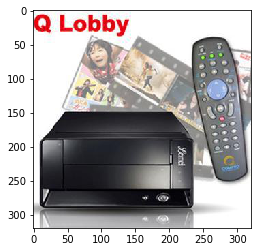

Epoch 1/20
89/89 [==============================] - 8s 95ms/step - loss: 1.1469 - acc: 0.5432
Epoch 2/20
89/89 [==============================] - 6s 68ms/step - loss: 0.7255 - acc: 0.6882
Epoch 3/20
89/89 [==============================] - 6s 67ms/step - loss: 0.6114 - acc: 0.7563
Epoch 4/20
89/89 [==============================] - 6s 68ms/step - loss: 0.5252 - acc: 0.7967
Epoch 5/20
89/89 [==============================] - 6s 67ms/step - loss: 0.4684 - acc: 0.8220
Epoch 6/20
89/89 [==============================] - 6s 68ms/step - loss: 0.3835 - acc: 0.8631
Epoch 7/20
89/89 [==============================] - 6s 68ms/step - loss: 0.3504 - acc: 0.8796
Epoch 8/20
89/89 [==============================] - 6s 68ms/step - loss: 0.3123 - acc: 0.8908
Epoch 9/20
89/89 [==============================] - 6s 68ms/step - loss: 0.2600 - acc: 0.9189
Epoch 10/20
89/89 [==============================] - 6s 68ms/step - loss: 0.2379 - acc: 0.9280
Epoch 11/20
89/89 [==============================] - 6s 67m

In [0]:

og_size = 320
pixelsizes = [320]  # 

for pixelsize in pixelsizes:
  if pixelsize != og_size:
    
    x_train = resizeDatasets(x_train_og,  pixelsize)
    x_val = resizeDatasets(x_val_og, pixelsize)  
    del x_train_og, x_val_og
  else:
    x_train = x_train_og
    x_val = x_val_og
  print("Train shape: {}".format(x_train.shape))
  print("Val shape: {}".format(x_val.shape))
  plt.imshow(x_train[2])
  plt.show()


  # Step 2: Create the model
  pixelsize = pixelsize
  model = Sequential()
  model.add(Conv2D(filters=16, kernel_size=(3, 3), strides=1, activation='relu', input_shape=(pixelsize, pixelsize, 3)))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=1, activation='relu', input_shape=((pixelsize-3+1-2+1), (pixelsize-3+1-2+1), 16)))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dropout(0.5))
  model.add(Dense(512, activation='relu'))
  model.add(Dense(3, activation='softmax'))

  model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0.0001),
                metrics=['accuracy'])

  # Step 3: Create the ART classifier
  max_pixel_value = 1. # since normalized
  classifier = KerasClassifier(model=model, clip_values=(min_pixel_value, max_pixel_value), use_logits=False)

  # Step 4: Train the ART classifier
  classifier.fit(x_train, y_train, batch_size=32, nb_epochs=20, shuffle=True)

  # Step 5: Evaluate the ART classifier on benign test examples
  predictions = classifier.predict(x_val)
  accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_val, axis=1)) / len(y_val)
  print('Accuracy on benign test examples: {}%'.format(accuracy * 100))

  # Step 6: Generate adversarial test examples
  attack = FastGradientMethod(classifier=classifier, eps=0.2)
  x_val_adv = attack.generate(x=x_val)

  # Step 7: Evaluate the ART classifier on adversarial test examples
  predictions = classifier.predict(x_val_adv)
  accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_val, axis=1)) / len(y_val)
  print('Accuracy on adversarial test examples: {}%'.format(accuracy * 100))

  del model, classifier, x_val_adv, x_train, x_val, predictions